This project focuses on implementing a system for recognizing gestures and movements in videos and images using a pre-trained deep learning model, enabling applications such as pose estimation, activity monitoring, and gesture-based interactions.

## Detecting body points

### Importing the libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np

### Loading the image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir /content/my_new_folder

In [5]:
image=cv2.imread('/content/my_new_folder/megan.jpg')

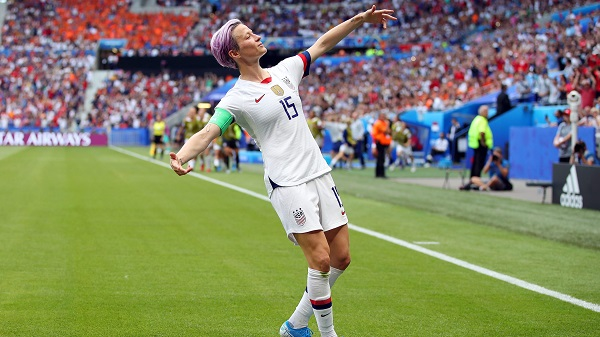

In [6]:
cv2_imshow(image)

In [8]:
image.shape,image.shape[0]*image.shape[1]*3

((337, 600, 3), 606600)

In [9]:
image_blob=cv2.dnn.blobFromImage(image=image,scalefactor=1.0/255,size=(image.shape[1],image.shape[0]))  #converting image to blob

In [12]:
type(image_blob),image_blob.shape #batch format 1-only one image

(numpy.ndarray, (1, 3, 337, 600))

### Loading the pre-trained neural network

In [14]:
network=cv2.dnn.readNetFromCaffe('/content/my_new_folder/pose_deploy_linevec_faster_4_stages.prototxt','/content/my_new_folder/pose_iter_160000.caffemodel') #neural network was loaded

In [ ]:
network.getLayerNames() #lists the name of layers

In [17]:
len(network.getLayerNames())

127

### Predicting body points

In [18]:
network.setInput(image_blob)
output=network.forward() #so the image will go to input layer and pass through all convolutional and pooling layers and finally reach the output layer

In [19]:
output.shape

(1, 44, 43, 75)

In [20]:
position_width=output.shape[3]
position_height=output.shape[2]

In [21]:
position_width

75

In [ ]:
num_points=15 #no of points
points=[]
for i in range(num_points):
  confidence_map=output[0,i,:,:]
  print(confidence_map)
  print(len(confidence_map))# so the neural networks will return 43 candidate points for each one of the points and we need to find the maximum value among them inorder to get the best one (the value with high confidence)


In [27]:
num_points=15 #no of points
points=[]
threshold=0.1
for i in range(num_points):
  confidence_map=output[0,i,:,:]
  #print(confidence_map)
  #print(len(confidence_map))# so the neural networks will return 43 candidate points for each one of the points and we need to find the maximum value among them inorder to get the best one (the value with high confidence)
  _,confidence,_,point=cv2.minMaxLoc(confidence_map)  #to find the maximum value and point
  #print(confidence)
  #print(point)

  x=int((image.shape[1]*point[0])/position_width)
  y=int((image.shape[0]*point[1])/position_height)
  if confidence>threshold:
    cv2.circle(image,(x,y),5,(0,255,0),thickness=-1)
    cv2.putText(image,'{}'.format(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))
    points.append((x,y))
  else:
    points.append(None)



In [28]:
points

[(224, 23),
 (248, 62),
 (232, 94),
 (208, 125),
 (176, 148),
 (280, 62),
 (320, 39),
 (360, 15),
 (288, 180),
 (320, 250),
 (320, 321),
 (312, 164),
 (336, 250),
 (296, 305),
 (280, 125)]

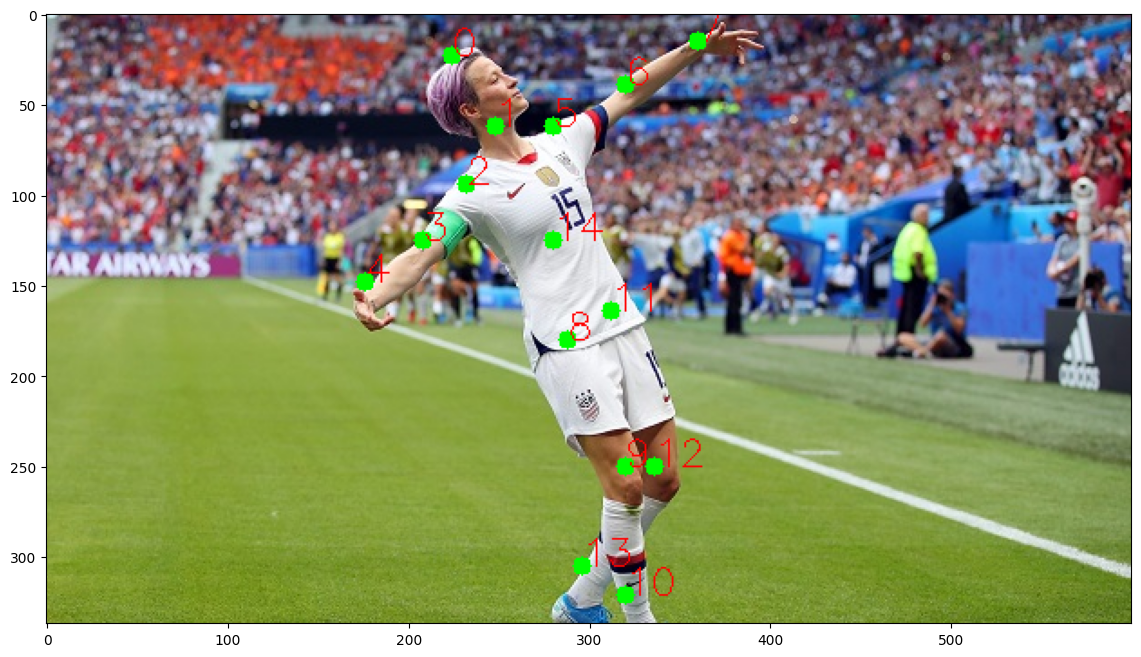

In [29]:
#Drawing points in the image
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));

In [30]:
#To draw lines connecting each points
point_connections=[[0,1],[1,2],[2,3],[3,4],[1,5],[5,6],[6,7],[1,14],[14,8],[8,9],[9,10],[14,11],[11,12],[12,13]]

In [31]:
point_connections

[[0, 1],
 [1, 2],
 [2, 3],
 [3, 4],
 [1, 5],
 [5, 6],
 [6, 7],
 [1, 14],
 [14, 8],
 [8, 9],
 [9, 10],
 [14, 11],
 [11, 12],
 [12, 13]]

In [32]:
for connection in point_connections:
  partA=connection[0]
  partB=connection[1]
  if points[partA] and points[partB]:
    cv2.line(image,points[partA],points[partB],(255,0,0))

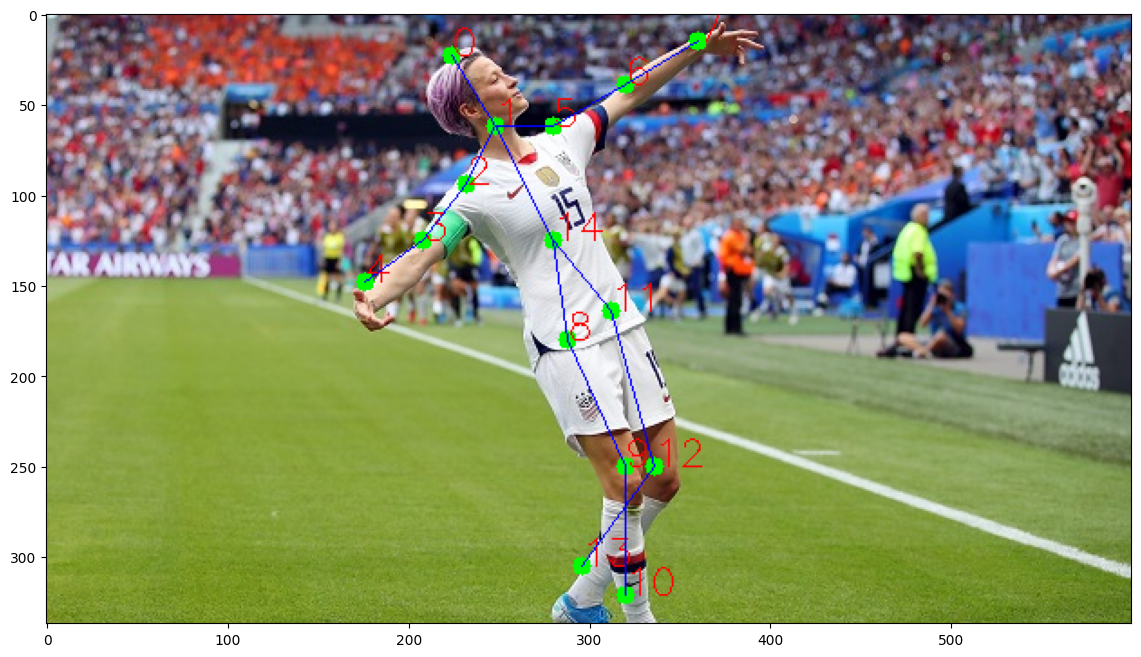

In [33]:
#Displaying the image
plt.figure(figsize=(14,10))
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));

# Detecting movements(arms above the head)

### Arms above the head in images

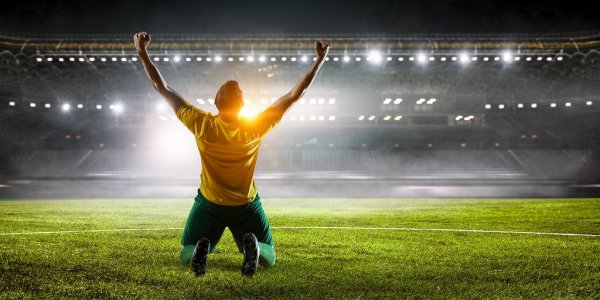

In [34]:
image2=cv2.imread('/content/my_new_folder/player.jpg')
cv2_imshow(image2)

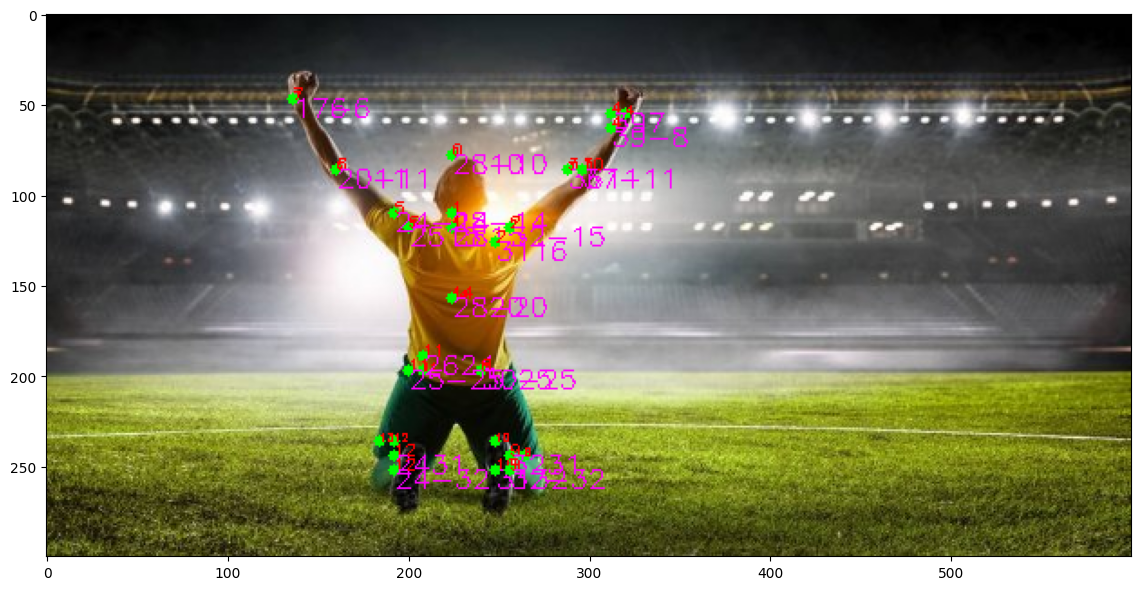

In [38]:
image_blob2=cv2.dnn.blobFromImage(image=image2,scalefactor=1.0/255,size=(image2.shape[1],image2.shape[0]))  #converting image to blob
network.setInput(image_blob2)
output2=network.forward()
position_width=output2.shape[3]
position_height=output2.shape[2]
num_points=15 #no of points
points=[]
threshold=0.1
for i in range(num_points):
  confidence_map=output2[0,i,:,:]
  #print(confidence_map)
  #print(len(confidence_map))# so the neural networks will return 43 candidate points for each one of the points and we need to find the maximum value among them inorder to get the best one (the value with high confidence)
  _,confidence,_,point=cv2.minMaxLoc(confidence_map)  #to find the maximum value and point
  #print(confidence)
  #print(point)

  x=int((image2.shape[1]*point[0])/position_width)
  y=int((image2.shape[0]*point[1])/position_height)
  if confidence>threshold:
    cv2.circle(image2,(x,y),3,(0,255,0),thickness=-1)
    cv2.putText(image2,'{}'.format(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.3,(0,0,255))
    cv2.putText(image2,'{}-{}'.format(point[0],point[1]),(x,y+10),cv2.FONT_HERSHEY_SIMPLEX,.5,(255,0,255))
    points.append((x,y))
  else:
    points.append(None)
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image2,cv2.COLOR_BGR2RGB));


From the figure while moving from top to bottom the value increases and if we move from left to right the value decreases

In [39]:
def verify_arms_up(points):
  head,right_wrist,left_wrist=0,0,0
  for i,point in enumerate(points):
    if i==0:
      head=point[1]
    elif i==4:
      right_wrist=point[1]
    elif i==7:
      left_wrist=point[1]
  if right_wrist<head and left_wrist<head:
    return True
  else:
    return False

In [40]:
verify_arms_up(points)

True

So both arms are above the head

### Arms above the head in videos

In [47]:
video='/content/my_new_folder/gesture1.mp4'
capture=cv2.VideoCapture(video)
connected,frame=capture.read()

In [48]:
connected

True

In [49]:
frame.shape

(1080, 808, 3)

In [50]:
result='/content/my_new_folder/gesture1_result.mp4'
save_video=cv2.VideoWriter(result,cv2.VideoWriter_fourcc(*'XVID'),10,(frame.shape[1],frame.shape[0]))

In [ ]:
threshold=0.1
while cv2.waitKey(1)<0:
  connected,frame=capture.read()

  if not connected:
    break

  image_blob=cv2.dnn.blobFromImage(image=frame,scalefactor=1.0/255,size=(256,256))  #converting image to blob
  network.setInput(image_blob)
  output=network.forward()
  position_width=output.shape[3]
  position_height=output.shape[2]
  num_points=15 #no of points
  points=[]

  for i in range(num_points):
    confidence_map=output[0,i,:,:]
  #print(confidence_map)
  #print(len(confidence_map))# so the neural networks will return 43 candidate points for each one of the points and we need to find the maximum value among them inorder to get the best one (the value with high confidence)
    _,confidence,_,point=cv2.minMaxLoc(confidence_map)  #to find the maximum value and point
  #print(confidence)
  #print(point)

    x=int((frame.shape[1]*point[0])/position_width)
    y=int((frame.shape[0]*point[1])/position_height)
    if confidence>threshold:
      cv2.circle(frame,(x,y),5,(0,255,0),thickness=-1)
      cv2.putText(frame,'{}'.format(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255))

      points.append((x,y))
    else:
      points.append(None)

  for connection in point_connections:
    partA=connection[0]
    partB=connection[1]
    if points[partA] and points[partB]:
      cv2.line(frame,points[partA],points[partB],(255,0,0))
  if verify_arms_up(points) == True:
    cv2.putText(frame,'Complete',(50,200),cv2.FONT_HERSHEY_COMPLEX,3,(0,0,255))

  cv2_imshow(frame)  #So here we are accessing frame by frame of this video
  save_video.write(frame)
save_video.release()

## Detecting movements(legs are apart)

### Considering images

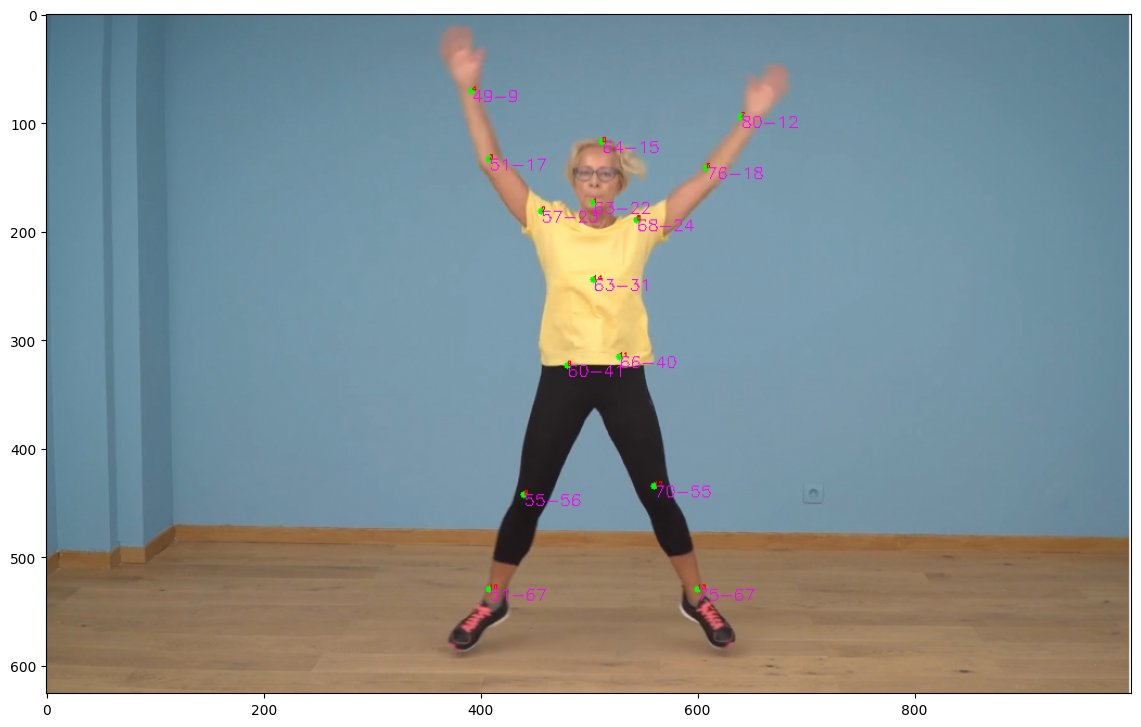

In [55]:
image=cv2.imread('/content/my_new_folder/jump.jpg')
image_blob=cv2.dnn.blobFromImage(image=image,scalefactor=1.0/255,size=(image.shape[1],image.shape[0]))  #converting image to blob
network.setInput(image_blob)
output=network.forward()
position_width=output.shape[3]
position_height=output.shape[2]
num_points=15 #no of points
points=[]
threshold=0.1
for i in range(num_points):
  confidence_map=output[0,i,:,:]
  #print(confidence_map)
  #print(len(confidence_map))# so the neural networks will return 43 candidate points for each one of the points and we need to find the maximum value among them inorder to get the best one (the value with high confidence)
  _,confidence,_,point=cv2.minMaxLoc(confidence_map)  #to find the maximum value and point
  #print(confidence)
  #print(point)

  x=int((image.shape[1]*point[0])/position_width)
  y=int((image.shape[0]*point[1])/position_height)
  if confidence>threshold:
    cv2.circle(image,(x,y),3,(0,255,0),thickness=-1)
    cv2.putText(image,'{}'.format(i),(x,y),cv2.FONT_HERSHEY_SIMPLEX,0.2,(0,0,255))
    cv2.putText(image,'{}-{}'.format(point[0],point[1]),(x,y+10),cv2.FONT_HERSHEY_SIMPLEX,.5,(255,0,255))
    points.append((x,y))
  else:
    points.append(None)
plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB));


From the figure while moving from left to right the value increases and if we move from top to bottom the value decreases

In [56]:
def verify_legs_apart(points):
  left_hip,right_hip=0,0
  left_ankle,right_ankle=0,0
  for i,point in enumerate(points):
    if i==11:
      left_hip=point[0]
    elif i==8:
      right_hip=point[0]
    elif i==13:
      left_ankle=point[0]
    elif i==10:
      right_ankle=point[0]
  if (left_ankle>left_hip) and(right_ankle<right_hip):
    return True
  else:
    return False

In [57]:
verify_legs_apart(points)

True

So it detects that the legs are apart